In [1]:
import pandas as pd
import time
import numpy as np
import re 
from datetime import datetime as dt
from datetime import timedelta 
import pickle
from random import *
from pysolar.solar import *

#plotting
from IPython.display import HTML, display
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter
%matplotlib inline

#modeling
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve

## Load Data

In [2]:
df = pd.read_csv('./data/df_all_processed.csv')
ndf = pd.read_csv('./data/ndf.csv')
ndf_tmc=pd.read_csv('./data/ndf_TMC.csv')
ramp = pd.read_csv('./data/ramp_exit.csv')

In [3]:
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

In [4]:
df = pd.merge(df, ramp, how = 'left', left_on = 'TMC', right_on = 'tmc')
ndf = pd.merge(ndf, ramp, how = 'left', left_on = 'TMC', right_on = 'tmc')

## Vertical Profile for ndf

In [6]:
g = pd.read_csv('./data/NJ3_grade.csv')
g.index = pd.IntervalIndex.from_arrays(g['MP ST'],g['MP END'],closed='both')

In [7]:
ndf['grade'] = ndf['MP'].apply(lambda x: g.iloc[g.index.get_loc(x)]['Grade EB'])
ndf['grade'] = np.where(ndf['direction']=='W', ndf['grade']*-1, ndf['grade'])

In [8]:
ndf = ndf.reset_index(drop=True)

## Density-Volume-Speed

In [9]:
#Density - Flow - Speed
df['density'] = (df['VOL']+df['TRK'])/df['spd']
ndf['density'] = (ndf['VOL']+ndf['TRK'])/ndf['spd']

In [10]:
df['target'] = 1
ndf['target'] = 0

## Additional Feature Engineering

* `speed (spd)`
* `solar_altitude`
* `solar_azimuth`
* `speed difference with downstream link 1 (dn1_spd_diff)`
* `speed difference with upstream link 1 (up1_spd_diff)`
* `mean speed for the previous 15-min (avg_spd_15min)`
* `mean speed for the previous 10-min (avg_spd_10min)`
* `mean speed for the previous 5-min (avg_spd_5min)`
* `speed standard deviation (SD) for the previous 15-min (std_15min)`
* `speed standard deviation (SD) for the previous 10-min (std_10min)`
* `speed standard deviation (SD) for the previous 5-min (std_5min)`
* `coefficient of variation (CV) for the previous 15-min (cv_15min)`
* `coefficient of variation (CV) for the previous 10-min (cv_10min)`
* `coefficient of variation (CV) for the previous 5-min (cv_5min)`
* `measn speed difference between upstream and downstream link for the previous 5-min (avg_spd_diff_up1dn1_5min)`
* `High Temperature (High)`
* `Low Temperature (Low)`
* `Precipitation amount (Precip.)`
* `Snow`
* `Snow depth (Snow d.)`
* `Link Capacity (CAPLINK)`
* `Hourly volume (VOL)`
* `Hourly truck volume (TRK)` 
* `Population Density (Pop_Dense)`
* `Vertical Profile (grade)`
* `Density (Density)`

In [11]:
float_feature_names = [
    'spd',
    'solar_altitude',
    'solar_azimuth',
    'dn1_spd_diff',
    'up1_spd_diff',
    'avg_spd_15min',
    'avg_spd_10min',
    'avg_spd_5min',
    'std_15min',
    'std_10min',
    'std_5min',
    'cv_15min',
    'cv_10min',
    'cv_5min',
    'avg_spd_diff_up1dn1_5min',
    'High',
    'Low',
    'Precip.',
    'Snow d.',
    'CAPLINK',
    'VOL',
    'TRK',
    'Pop_Dense',
    'density',
    'grade'
   
]

### Binary Features

In [12]:
binary_feature_names = ['direction_','RAMP']

### Temporal Features

In [13]:
temporal_feature_names = ['hour', 'month', 'weekday']

### Reponse Feature

In [14]:
res_feature_names = ['target']

In [15]:
df1 = df.xs(float_feature_names+binary_feature_names+temporal_feature_names+res_feature_names, axis=1)
ndf1 = ndf.xs(float_feature_names+binary_feature_names+temporal_feature_names+res_feature_names, axis=1)

In [16]:
df_ = pd.concat([df1, ndf1])
df_ = df_.sample(frac=1).reset_index(drop=True)

In [17]:
df_ = df_.dropna()

In [18]:
df_.isna().sum(axis=0)

spd                         0
solar_altitude              0
solar_azimuth               0
dn1_spd_diff                0
up1_spd_diff                0
avg_spd_15min               0
avg_spd_10min               0
avg_spd_5min                0
std_15min                   0
std_10min                   0
std_5min                    0
cv_15min                    0
cv_10min                    0
cv_5min                     0
avg_spd_diff_up1dn1_5min    0
High                        0
Low                         0
Precip.                     0
Snow d.                     0
CAPLINK                     0
VOL                         0
TRK                         0
Pop_Dense                   0
density                     0
grade                       0
direction_                  0
RAMP                        0
hour                        0
month                       0
weekday                     0
target                      0
dtype: int64

In [19]:
float_features = df_.xs(float_feature_names,axis=1).values
# Use scikit-learn's StandardScaler
scaler = StandardScaler()
float_scaled = scaler.fit_transform(float_features)

df_[float_feature_names] = float_scaled

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)

In [20]:
cat_feature = ['direction_','RAMP', 'hour', 'month', 'weekday']
df_ = pd.get_dummies(df_,columns=cat_feature)

# Get the one-hot variable names
#cat_feature_names = pd.get_dummies(df_[cat_feature],columns=cat_feature).columns.tolist()

In [21]:
X = df_.drop('target', axis=1).values
y = df_['target'].values
feature_names = df_.drop('target',axis =1).columns.tolist()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = True, random_state=10)

print (X_train.shape,y_train.shape)
print (X_test.shape,y_test.shape)
X_train = xgb.DMatrix(X_train,label=y_train,feature_names=feature_names)
X_test =  xgb.DMatrix(X_test,label=y_test,feature_names=feature_names)
# params = {
#     'n_estimators': 2000,
#     'max_depth':6,
#     'reg_lambda': 0.0,
#     'reg_alpha':1.0
# }

params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.5
}



booster = xgb.train(params,X_train)

y_pred_test = np.round(booster.predict(X_test))
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

num_accidents_predicted_correctly = np.sum((y_test > 0) * (y_pred_test > 0))
num_accidents = np.sum(y_test > 0)

print ('Fraction Predicted:',num_accidents_predicted_correctly/float(num_accidents))
print ('Fraction False Alarm',(np.sum(y_pred_test>0) - num_accidents_predicted_correctly)/float(num_accidents))
y_pred_train = np.round(booster.predict(X_train))
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

(19267, 72) (19267,)
(10376, 72) (10376,)
Test Accuracy: 0.8600616808018504
Test F1: 0.49016853932584276
Test Precision: 0.7481243301178992
Test Recall: 0.36449086161879896
Test AUC: 0.8346506147234292
Fraction Predicted: 1.0
Fraction False Alarm 4.418276762402089
Train Accuracy: 0.8699330461410703
Train F1: 0.5408574569439355
Train Precision: 0.8132231404958677
Train Recall: 0.4051605819379632
Train AUC: 0.8737289837112299


In [24]:
booster = xgb.train(params,X_train,
    evals = [(X_test, 'eval')],
    num_boost_round=3000,
    early_stopping_rounds=25
)

[0]	eval-auc:0.741136
Will train until eval-auc hasn't improved in 25 rounds.
[1]	eval-auc:0.755665
[2]	eval-auc:0.772049
[3]	eval-auc:0.79866
[4]	eval-auc:0.807203
[5]	eval-auc:0.8165
[6]	eval-auc:0.819263
[7]	eval-auc:0.821891
[8]	eval-auc:0.82287
[9]	eval-auc:0.834651
[10]	eval-auc:0.840654
[11]	eval-auc:0.840613
[12]	eval-auc:0.841672
[13]	eval-auc:0.840891
[14]	eval-auc:0.843679
[15]	eval-auc:0.847908
[16]	eval-auc:0.848066
[17]	eval-auc:0.848007
[18]	eval-auc:0.849227
[19]	eval-auc:0.847621
[20]	eval-auc:0.846263
[21]	eval-auc:0.846737
[22]	eval-auc:0.84682
[23]	eval-auc:0.848095
[24]	eval-auc:0.847476
[25]	eval-auc:0.847345
[26]	eval-auc:0.847062
[27]	eval-auc:0.845402
[28]	eval-auc:0.845371
[29]	eval-auc:0.84561
[30]	eval-auc:0.845374
[31]	eval-auc:0.84585
[32]	eval-auc:0.846356
[33]	eval-auc:0.846262
[34]	eval-auc:0.845587
[35]	eval-auc:0.845349
[36]	eval-auc:0.845318
[37]	eval-auc:0.844817
[38]	eval-auc:0.844772
[39]	eval-auc:0.844896
[40]	eval-auc:0.84405
[41]	eval-auc:0.843

Text(0, 0.5, 'Features')

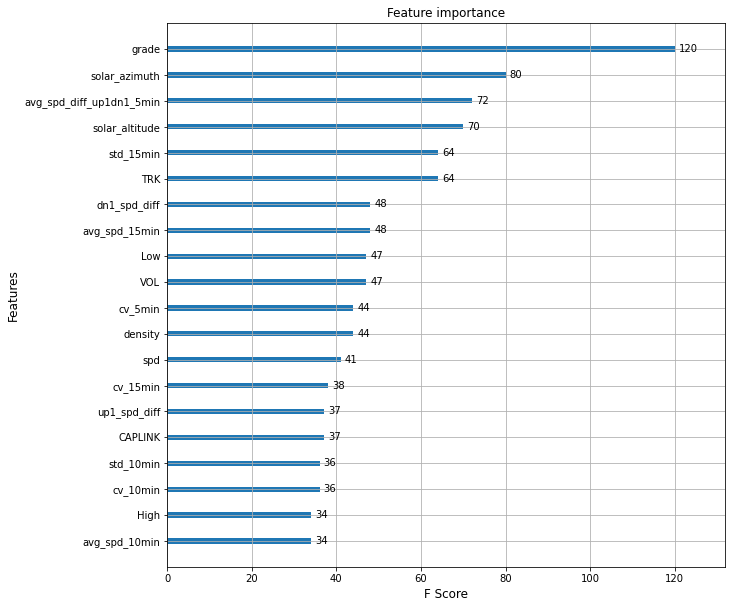

In [25]:
plt.figure(figsize=(10,10))
xgb.plot_importance(booster,ax=plt.gca(),importance_type='weight', max_num_features=20)
plt.xlabel('F Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

Text(0, 0.5, 'Features')

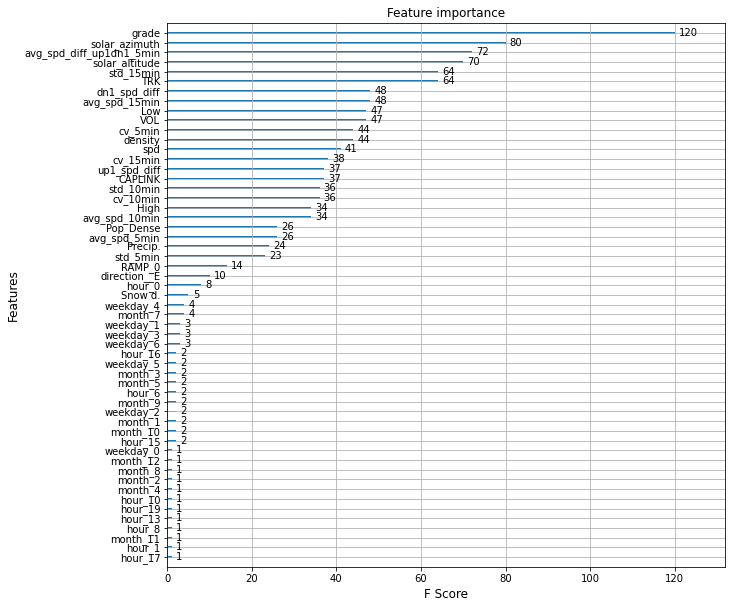

In [26]:
plt.figure(figsize=(10,10))
xgb.plot_importance(booster,ax=plt.gca(),importance_type='weight')
plt.xlabel('F Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

In [27]:
print(df_.groupby('target').size())

target
0    24085
1     5558
dtype: int64


## Imbalanced Data - SMOTE

In [31]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

x1 = df_.drop('target', axis=1)
y1 = df_['target']

'''Increase the crash samples from 5558 to 10000'''

sm = SMOTE(random_state=42,sampling_strategy={1:10000})
X_res, y_res = sm.fit_sample(x1, y1)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 24085, 1: 10000})


In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(X_res, y_res, test_size=0.30, random_state=0)
print('xtrain shape')
print(xtrain.shape)
print('xtest shape')
print(xtest.shape)

xtrain shape
(23859, 72)
xtest shape
(10226, 72)


In [33]:
# Extreme Gradient Boost Algorithm on reduced dimensions data

from xgboost.sklearn import XGBClassifier

# Create the XGB classifier, xgb_model.
xgb_model = XGBClassifier()

# List the default parameters.
print(xgb_model.get_xgb_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'verbosity': 1}


In [34]:
# Train and evaluate.
xgb_model.fit(xtrain, ytrain, eval_metric=['error'], eval_set=[((xtrain, ytrain)),(xtest, ytest)])

[0]	validation_0-error:0.246448	validation_1-error:0.250636
[1]	validation_0-error:0.238568	validation_1-error:0.239879
[2]	validation_0-error:0.238401	validation_1-error:0.24027
[3]	validation_0-error:0.237856	validation_1-error:0.23939
[4]	validation_0-error:0.236808	validation_1-error:0.238412
[5]	validation_0-error:0.235802	validation_1-error:0.238216
[6]	validation_0-error:0.234293	validation_1-error:0.236652
[7]	validation_0-error:0.233371	validation_1-error:0.235869
[8]	validation_0-error:0.23379	validation_1-error:0.236163
[9]	validation_0-error:0.233497	validation_1-error:0.236456
[10]	validation_0-error:0.232742	validation_1-error:0.235478
[11]	validation_0-error:0.232742	validation_1-error:0.235283
[12]	validation_0-error:0.23182	validation_1-error:0.235283
[13]	validation_0-error:0.231108	validation_1-error:0.235185
[14]	validation_0-error:0.230689	validation_1-error:0.234794
[15]	validation_0-error:0.230018	validation_1-error:0.233425
[16]	validation_0-error:0.228509	valid

XGBClassifier()

In [35]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

y_pred = xgb_model.predict(xtest)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest, y_pred))
print('classification report')
print(metrics.classification_report(ytest, y_pred))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest, y_pred))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest, y_pred)))

confusion matrix
[[6856  332]
 [1459 1579]]
classification report
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7188
           1       0.83      0.52      0.64      3038

    accuracy                           0.82     10226
   macro avg       0.83      0.74      0.76     10226
weighted avg       0.83      0.82      0.81     10226

-----------------------------------------------------------------------------------------
Accuracy is :
0.8248582045765696
Area under the curve : 0.736781


In [36]:
print ('Test Accuracy:',accuracy_score(ytest,y_pred))
print ('Test F1:',f1_score(ytest,y_pred))
print ('Test Precision:',precision_score(ytest,y_pred))
print ('Test Recall:',recall_score(ytest,y_pred))

Test Accuracy: 0.8248582045765696
Test F1: 0.6381087088300667
Test Precision: 0.826268969126112
Test Recall: 0.5197498354180382


In [37]:
params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.5
}


In [38]:
xgb_model1 = XGBClassifier().set_params(max_depth = 6, min_child_weight = 5, reg_lambda = 1, reg_alpha =0,
                                       scale_pos_weight = 1, objective = 'binary:logistic', eta = 0.4)

In [39]:
xgb_model1.fit(xtrain, ytrain, eval_metric=['error'], eval_set=[((xtrain, ytrain)),(xtest, ytest)])

[0]	validation_0-error:0.226288	validation_1-error:0.23098
[1]	validation_0-error:0.220504	validation_1-error:0.226286
[2]	validation_0-error:0.214804	validation_1-error:0.220027
[3]	validation_0-error:0.214133	validation_1-error:0.219343
[4]	validation_0-error:0.213211	validation_1-error:0.220321
[5]	validation_0-error:0.207175	validation_1-error:0.214062
[6]	validation_0-error:0.20508	validation_1-error:0.21152
[7]	validation_0-error:0.200805	validation_1-error:0.207999
[8]	validation_0-error:0.200847	validation_1-error:0.208097
[9]	validation_0-error:0.199715	validation_1-error:0.208195
[10]	validation_0-error:0.198248	validation_1-error:0.207021
[11]	validation_0-error:0.194308	validation_1-error:0.203696
[12]	validation_0-error:0.192338	validation_1-error:0.201252
[13]	validation_0-error:0.190662	validation_1-error:0.198807
[14]	validation_0-error:0.188357	validation_1-error:0.19646
[15]	validation_0-error:0.186345	validation_1-error:0.195482
[16]	validation_0-error:0.184501	valid

XGBClassifier(eta=0.4, max_depth=6, min_child_weight=5)

In [40]:
warnings.filterwarnings("ignore")

y_pred1 = xgb_model1.predict(xtest)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest, y_pred1))
print('classification report')
print(metrics.classification_report(ytest, y_pred1))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest, y_pred1))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest, y_pred1)))

confusion matrix
[[6948  240]
 [1110 1928]]
classification report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      7188
           1       0.89      0.63      0.74      3038

    accuracy                           0.87     10226
   macro avg       0.88      0.80      0.83     10226
weighted avg       0.87      0.87      0.86     10226

-----------------------------------------------------------------------------------------
Accuracy is :
0.8679835712888715
Area under the curve : 0.800620


In [41]:
warnings.filterwarnings("ignore")

y_pred1 = xgb_model1.predict(xtest)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest, y_pred1))
print('classification report')
print(metrics.classification_report(ytest, y_pred1))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest, y_pred1))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest, y_pred1)))

confusion matrix
[[6948  240]
 [1110 1928]]
classification report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      7188
           1       0.89      0.63      0.74      3038

    accuracy                           0.87     10226
   macro avg       0.88      0.80      0.83     10226
weighted avg       0.87      0.87      0.86     10226

-----------------------------------------------------------------------------------------
Accuracy is :
0.8679835712888715
Area under the curve : 0.800620


In [42]:
print ('Test Accuracy:',accuracy_score(ytest,y_pred1))
print ('Test F1:',f1_score(ytest,y_pred1))
print ('Test Precision:',precision_score(ytest,y_pred1))
print ('Test Recall:',recall_score(ytest,y_pred1))

Test Accuracy: 0.8679835712888715
Test F1: 0.7406838263542067
Test Precision: 0.8892988929889298
Test Recall: 0.6346280447662936


### SMOTE Senario 2
12500

In [43]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

x2 = df_.drop('target', axis=1)
y2 = df_['target']

'''Increase the crash samples from 5558 to 10000'''

sm = SMOTE(random_state=42,sampling_strategy={1:12500})
X_res1, y_res1 = sm.fit_sample(x2, y2)
print('Resampled dataset shape {}'.format(Counter(y_res1)))

Resampled dataset shape Counter({0: 24085, 1: 12500})


In [44]:
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(X_res1, y_res1, test_size=0.30, random_state=10)
print('xtrain shape')
print(xtrain1.shape)
print('xtest shape')
print(xtest1.shape)

xtrain shape
(25609, 72)
xtest shape
(10976, 72)


In [45]:
xgb_model1.fit(xtrain1, ytrain1, eval_metric=['error'], eval_set=[((xtrain1, ytrain1)),(xtest1, ytest1)])

[0]	validation_0-error:0.242337	validation_1-error:0.249909
[1]	validation_0-error:0.23031	validation_1-error:0.237427
[2]	validation_0-error:0.229607	validation_1-error:0.238156
[3]	validation_0-error:0.224882	validation_1-error:0.233236
[4]	validation_0-error:0.214963	validation_1-error:0.225674
[5]	validation_0-error:0.20813	validation_1-error:0.218203
[6]	validation_0-error:0.202976	validation_1-error:0.212372
[7]	validation_0-error:0.201179	validation_1-error:0.211097
[8]	validation_0-error:0.19747	validation_1-error:0.208637
[9]	validation_0-error:0.193994	validation_1-error:0.204537
[10]	validation_0-error:0.193174	validation_1-error:0.202442
[11]	validation_0-error:0.19048	validation_1-error:0.199617
[12]	validation_0-error:0.189777	validation_1-error:0.199435
[13]	validation_0-error:0.18841	validation_1-error:0.19816
[14]	validation_0-error:0.187786	validation_1-error:0.197157
[15]	validation_0-error:0.183256	validation_1-error:0.193604
[16]	validation_0-error:0.181069	validat

XGBClassifier(eta=0.4, max_depth=6, min_child_weight=5)

In [46]:
warnings.filterwarnings("ignore")

y_pred1 = xgb_model1.predict(xtest1)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest1, y_pred1))
print('classification report')
print(metrics.classification_report(ytest1, y_pred1))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest1, y_pred1))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest1, y_pred1)))

confusion matrix
[[6877  306]
 [1079 2714]]
classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7183
           1       0.90      0.72      0.80      3793

    accuracy                           0.87     10976
   macro avg       0.88      0.84      0.85     10976
weighted avg       0.88      0.87      0.87     10976

-----------------------------------------------------------------------------------------
Accuracy is :
0.8738155976676385
Area under the curve : 0.836464


## SMOTE Senario 3
15000

In [47]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

x3 = df_.drop('target', axis=1)
y3 = df_['target']

'''Increase the crash samples from 5558 to 10000'''

sm = SMOTE(random_state=42,sampling_strategy={1:15000})
X_res2, y_res2 = sm.fit_sample(x3, y3)
print('Resampled dataset shape {}'.format(Counter(y_res2)))

Resampled dataset shape Counter({0: 24085, 1: 15000})


In [48]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(X_res2, y_res2, test_size=0.30, random_state=20)
print('xtrain shape')
print(xtrain2.shape)
print('xtest shape')
print(xtest2.shape)

xtrain shape
(27359, 72)
xtest shape
(11726, 72)


In [49]:
xgb_model1.fit(xtrain2, ytrain2, eval_metric=['error'], eval_set=[((xtrain2, ytrain2)),(xtest2, ytest2)])

[0]	validation_0-error:0.267773	validation_1-error:0.27341
[1]	validation_0-error:0.252787	validation_1-error:0.258741
[2]	validation_0-error:0.251142	validation_1-error:0.259423
[3]	validation_0-error:0.246025	validation_1-error:0.254221
[4]	validation_0-error:0.2359	validation_1-error:0.242026
[5]	validation_0-error:0.232794	validation_1-error:0.237336
[6]	validation_0-error:0.224241	validation_1-error:0.227443
[7]	validation_0-error:0.219087	validation_1-error:0.224714
[8]	validation_0-error:0.215944	validation_1-error:0.222241
[9]	validation_0-error:0.206513	validation_1-error:0.211922
[10]	validation_0-error:0.200885	validation_1-error:0.205526
[11]	validation_0-error:0.196791	validation_1-error:0.202968
[12]	validation_0-error:0.194817	validation_1-error:0.20075
[13]	validation_0-error:0.191491	validation_1-error:0.19606
[14]	validation_0-error:0.187141	validation_1-error:0.19009
[15]	validation_0-error:0.184766	validation_1-error:0.189152
[16]	validation_0-error:0.184473	validat

XGBClassifier(eta=0.4, max_depth=6, min_child_weight=5)

In [50]:
warnings.filterwarnings("ignore")

y_pred2 = xgb_model1.predict(xtest2)  #predicts
print('confusion matrix')
print(metrics.confusion_matrix(ytest2, y_pred2))
print('classification report')
print(metrics.classification_report(ytest2, y_pred2))
print("-----------------------------------------------------------------------------------------")
print("Accuracy is :")
print(metrics.accuracy_score(ytest2, y_pred2))
print('Area under the curve : %f' % (metrics.roc_auc_score(ytest2, y_pred2)))

confusion matrix
[[6898  336]
 [1017 3475]]
classification report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7234
           1       0.91      0.77      0.84      4492

    accuracy                           0.88     11726
   macro avg       0.89      0.86      0.87     11726
weighted avg       0.89      0.88      0.88     11726

-----------------------------------------------------------------------------------------
Accuracy is :
0.8846153846153846
Area under the curve : 0.863575


In [51]:
# Get numerical feature importances
importances_xgb = list(xgb_model.feature_importances_)

# List of tuples with variable and importance
feature_importances_xgb = [(feature, round(importance, 5)) for feature, importance in zip(xtrain.columns, importances_xgb)]

# Sort the feature importances by most important first
xgb_feature_importances = sorted(feature_importances_xgb, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in xgb_feature_importances]

Variable: density              Importance: 0.10987000167369843
Variable: spd                  Importance: 0.09250999987125397
Variable: std_5min             Importance: 0.07569999992847443
Variable: avg_spd_5min         Importance: 0.05635000020265579
Variable: direction__E         Importance: 0.054030001163482666
Variable: up1_spd_diff         Importance: 0.05040999874472618
Variable: dn1_spd_diff         Importance: 0.04259999841451645
Variable: Precip.              Importance: 0.041430000215768814
Variable: RAMP_1               Importance: 0.029330000281333923
Variable: CAPLINK              Importance: 0.02831999957561493
Variable: avg_spd_10min        Importance: 0.025499999523162842
Variable: avg_spd_diff_up1dn1_5min Importance: 0.022910000756382942
Variable: avg_spd_15min        Importance: 0.021800000220537186
Variable: grade                Importance: 0.0203000009059906
Variable: RAMP_0               Importance: 0.019710000604391098
Variable: solar_altitude       Importance: 0.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [52]:
xgb_feature_importances_top20 = xgb_feature_importances[:20]
featureNames, featureScores = zip(*list(xgb_feature_importances_top20))

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle = True, random_state=10)

print (X_train.shape,y_train.shape)
print (X_test.shape,y_test.shape,"\n")
X_train = xgb.DMatrix(X_train,label=y_train,feature_names=feature_names)
X_test =  xgb.DMatrix(X_test,label=y_test,feature_names=feature_names)
# params = {
#     'n_estimators': 2000,
#     'max_depth':6,
#     'reg_lambda': 0.0,
#     'reg_alpha':1.0
# }

params = {
#     'learning_rate': 0.1,
#     'n_estimators':1000,
#     'max_depth':7,
#     'min_child_weight':5,
#     'gamma':0.4,
#     'subsample':0.8,
#     'colsample_bytree':0.8,
#     'objective': 'binary:logistic',
#     'nthread':4,
#     'scale_pos_weight':1,
#     'seed':27
    'learning_rate':0.1,      
    'max_depth':7,
    'min_child_weight': 5,
    'gamma':0.4,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.5
}

booster = xgb.train(params,X_train)

y_pred_test = np.round(booster.predict(X_test))
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

num_accidents_predicted_correctly = np.sum((y_test > 0) * (y_pred_test > 0))
num_accidents = np.sum(y_test > 0)

print(num_accidents_predicted_correctly)
print(num_accidents,"\n")

print ('Fraction Predicted:',num_accidents_predicted_correctly/float(num_accidents))
print ('Fraction False Alarm',(np.sum(y_pred_test>0) - num_accidents_predicted_correctly)/float(num_accidents))
y_pred_train = np.round(booster.predict(X_train))
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

(19267, 72) (19267,)
(10376, 72) (10376,) 

Test Accuracy: 0.843195836545875
Test F1: 0.38254269449715367
Test Precision: 0.7
Test Recall: 0.26318537859007834
Test AUC: 0.7844760308625384
1915
1915 

Fraction Predicted: 1.0
Fraction False Alarm 4.418276762402089
Train Accuracy: 0.8520267815435719
Train F1: 0.43844790230451053
Train Precision: 0.7761506276150628
Train Recall: 0.30551743068899256
Train AUC: 0.8164841715392706


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

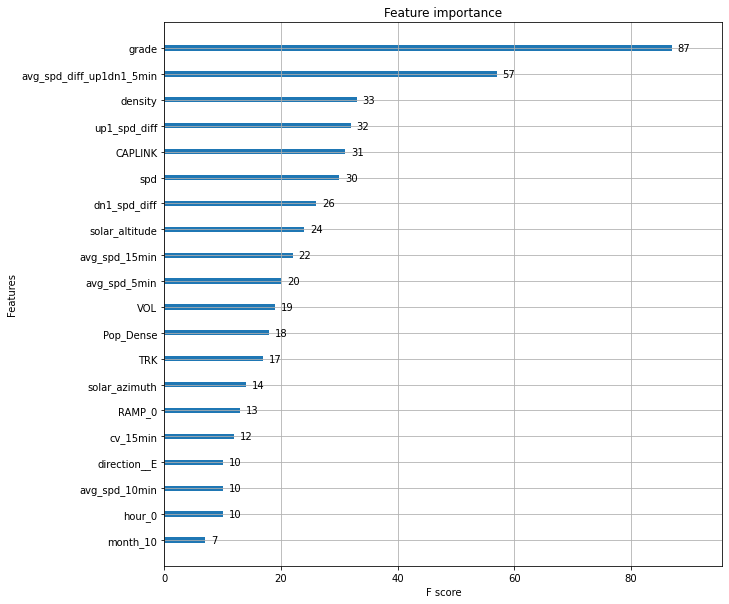

In [55]:
plt.figure(figsize=(10,10))
xgb.plot_importance(booster,ax=plt.gca(),importance_type='weight', max_num_features=20)

In [56]:
dtrain1 = xgb.DMatrix(xtrain,label=ytrain,feature_names=feature_names)
dtest1 =  xgb.DMatrix(xtest,label=ytest,feature_names=feature_names)

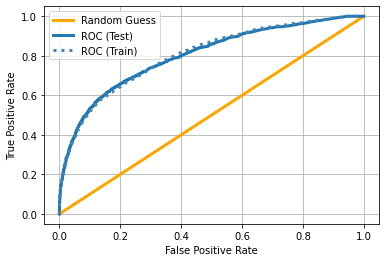

In [57]:
y_pred_test = booster.predict(dtest1)

fpr, tpr, thresholds = roc_curve(ytest,y_pred_test)

y_pred_train = booster.predict(dtrain1)
fpr_train, tpr_train, thresholds_train = roc_curve(ytrain,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

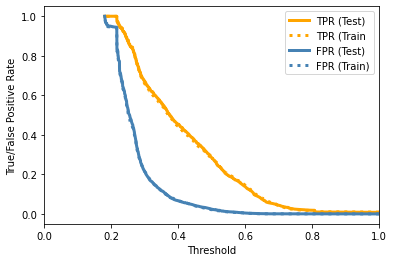

In [58]:
plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('True/False Positive Rate')
plt.legend()

'3.3.3'

<Figure size 1080x1080 with 0 Axes>

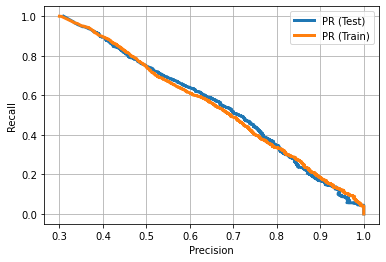

In [59]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(dtest1)
y_pred_train = booster.predict(dtrain1)

precision,recall,thresholds = precision_recall_curve(ytest,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(ytrain,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.matplotlib.__version__

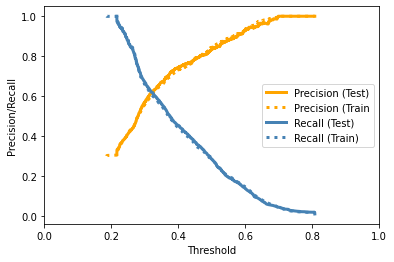

In [60]:
plt.plot(thresholds,precision[:-1],'r-',label='Precision (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='Precision (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='Recall (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='Recall (Train)',color='steelblue',lw=3)
#plt.plot([0,1],[0,1],'k-',lw=2)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()

In [ ]:
y_pred_test = booster.predict(dtest1) > 0.32
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(dtest1)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))

y_pred_train = booster.predict(dtrain) > 0.32
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(dtrain)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))

In [69]:
#Density - Flow - Speed
df_1['density1'] = df['VOL']/df['spd']

#ndf['density'] = (ndf['VOL']+ndf['TRK'])/ndf['spd']

In [70]:
df_1 = pd.concat([df1, ndf1])
df_1 = df_1.sample(frac=1).reset_index(drop=True)

Density - Speed


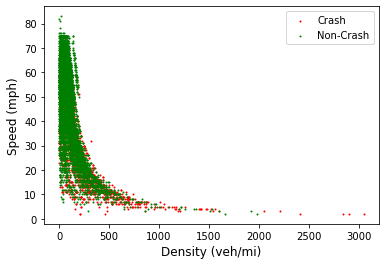

<Figure size 432x288 with 0 Axes>

In [73]:
non_crash = df_1[df_1['target']==0]
crash = df_1[df_1['target']==1]
print('Density - Speed')
plt.scatter(crash['density'], crash['spd'],s=1, color='r', label='Crash')

plt.scatter(non_crash['density'], non_crash['spd'], s=1, color='g', label ='Non-Crash')

plt.legend()
plt.xlabel('Density (veh/mi)', fontsize=12)
plt.ylabel('Speed (mph)', fontsize=12)

plt.show()

plt.clf()

In [74]:
df_1['volume'] = df_1['VOL']+df_1['TRK']

Flow - Speed


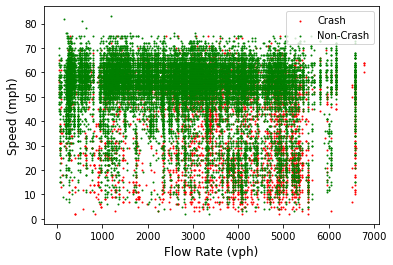

<Figure size 432x288 with 0 Axes>

In [75]:
non_crash = df_1[df_1['target']==0]
crash = df_1[df_1['target']==1]
print('Flow - Speed')
plt.scatter(crash['VOL'], crash['spd'],s=1, color='red', label = 'Crash')
plt.scatter(non_crash['VOL'], non_crash['spd'], s=1, color='green', label = 'Non-Crash')
plt.legend()
plt.xlabel('Flow Rate (vph)', fontsize=12)
plt.ylabel('Speed (mph)', fontsize=12)
plt.show()
plt.clf()

Flow - Speed


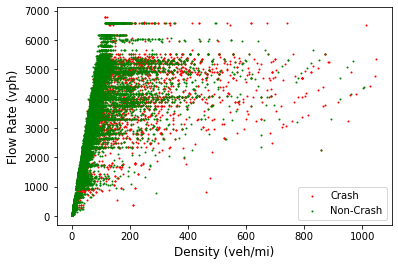

<Figure size 432x288 with 0 Axes>

In [77]:
df_2 = df_1[df_1['density']<1050]

non_crash = df_2[df_2['target']==0]
crash = df_2[df_2['target']==1]
print('Flow - Speed')
plt.scatter(crash['density'], crash['VOL'],s=1, color='r', label='Crash')
plt.scatter(non_crash['density'], non_crash['VOL'], s=1, color='g', label='Non-Crash')
plt.legend()
plt.xlabel('Density (veh/mi)', fontsize=12)
plt.ylabel('Flow Rate (vph)', fontsize=12)
plt.show()
plt.clf()

Density - Speed


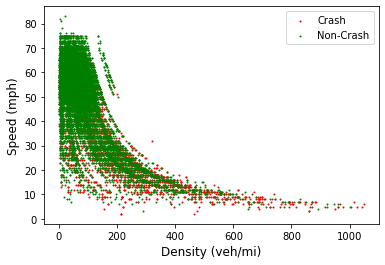

<Figure size 432x288 with 0 Axes>

In [36]:
non_crash = df_2[df_2['target']==0]
crash = df_2[df_2['target']==1]
print('Density - Speed')
plt.scatter(crash['density'], crash['spd'],s=1, color='r', label='Crash')

plt.scatter(non_crash['density'], non_crash['spd'], s=1, color='g', label ='Non-Crash')

plt.legend()
plt.xlabel('Density (veh/mi)', fontsize=12)
plt.ylabel('Speed (mph)', fontsize=12)

plt.show()

plt.clf()

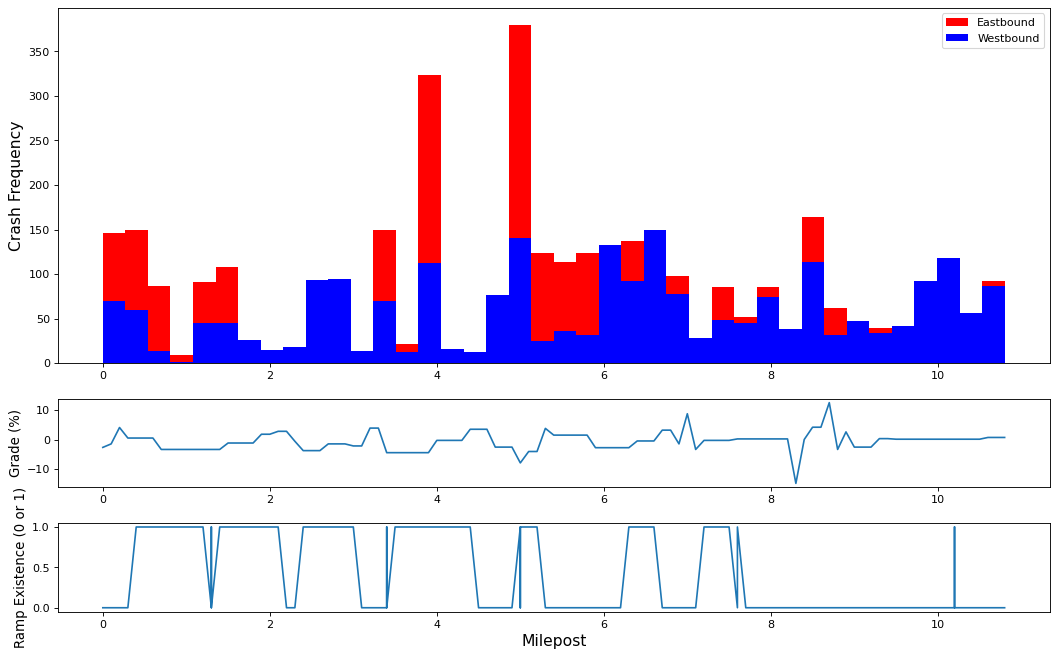

In [129]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def annotate_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=True, labelleft=True)

fig = plt.figure(figsize=(16, 10), dpi= 80)

#fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")

legend=['Eastbound', 'Westbound']
gs = GridSpec(3, 1, height_ratios=[4, 1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

ax1.hist([df_E['MP'], df_W['MP']], 40, histtype='stepfilled', orientation='vertical', color =['blue', 'red'])
ax2.plot(df_E['MP'], df_E['grade'])
ax3.plot(df_E['MP'], df_E['RAMP'])

ax1.set_ylabel('Crash Frequency', fontsize=14)
ax2.set_ylabel('Grade (%)', fontsize = 12)
ax3.set_ylabel('Ramp Existence (0 or 1)', fontsize= 12)
ax3.set_xlabel('Milepost', fontsize=14)

ax1.legend(legend)

# xlabels = ax1.get_xticks().tolist()
# ax1.set_xticklabels(xlabels)

plt.show()